In [1]:
from mlflow import MlflowClient
import mlflow
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
from itertools import product
import os
import sys
from pathlib import Path
cwd = Path.cwd()
parent = cwd.parent
sys.path.append(str(parent))


from Source.preprocess_data import *  ## import all functions from preprocess_data.py
from Source.postprocess_data import * ## import all functions from postprocess_data.py
from Source.utils import *  ## import all functions from utils.py
import nltk


client = MlflowClient(tracking_uri="http://localhost:8080")

mlruns_path = Path("../mlruns").resolve() 
mlflow_uri = mlruns_path.as_uri()
mlflow.set_tracking_uri(mlflow_uri)


c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


# Prétraitement du dataset


## Extraction d'un faible pourcentage de tweets

In [2]:
df = pd.read_csv('https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip',
                header=None,
                compression='zip',
                encoding='cp1252')

df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
data_size = 0.02
sample_df, _ = train_test_split(df, test_size=1-data_size, random_state=42, stratify=df['target'])
sample_df = sample_df.reset_index(drop=True)
print(f"Sample size: {sample_df.shape[0]} rows")
data_numrows = sample_df.shape[0]
# On ne garde que les colonnes 'target' et 'text'
sample_df = sample_df[['target', 'text']]
sample_df["target"] = sample_df["target"].apply(lambda x: 0 if x == 0 else 1)
sample_df.to_csv('../Data/raw_data.csv', index=False)
dataset = mlflow.data.from_pandas(
    sample_df,
    source="../Data/raw_data.csv",
    name="dataset_v1"
)


Sample size: 32000 rows


c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../Data/raw_data.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(


## Normalisation du texte

In [3]:
# Normalisation du texte
sample_df['text'] = sample_df['text'].apply(lambda x: normalize_text(x))
# Enregistrement du jeu de données pré-traité
sample_df.to_csv('../Data/normalized_data.csv', index=False)
print(f"Normalized {sample_df.shape[0]} rows")


Normalized 32000 rows


## Tokenisation

In [4]:
#Stopwords
nltk.download('stopwords')
#Vocabulaire
nltk.download('words')
#Punctuation
nltk.download('punkt_tab')
#Wordnet
nltk.download('wordnet')
#POS-tagging
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bassm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bassm\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bassm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bassm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\bassm\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

<Axes: xlabel='target', ylabel='count'>

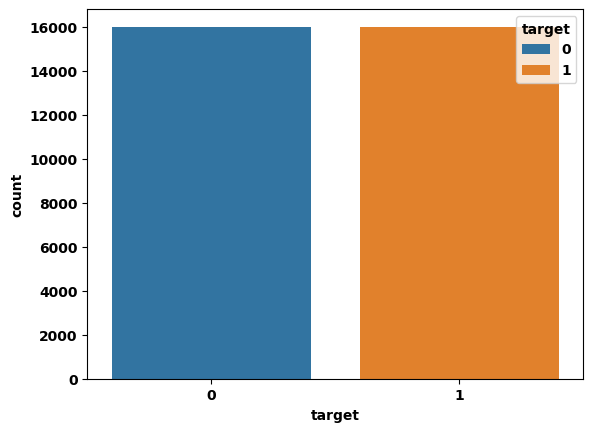

In [5]:
sns.countplot(x='target',hue='target', data=sample_df)

Dataset équilibré, pas besoin de rééquilibrer la cible.  

## Experimentation sur l'impact du feature engineering (tokenisation, stemming/lemmatisation, vectorisation) 

### Mise en place de l'environnement MLFlow

In [6]:
# Provide an Experiment description that will appear in the UI

mlflow.set_experiment("Tokenization experiment")
exp_id = mlflow.get_experiment_by_name("Tokenization experiment").experiment_id

experiment_description = (
    "Cette experience contient les différents tests pour le <<modèle sur mesure simple>>. "
    "Le but est d'évaluer un modèle simple permettant d'évaluer les sentiments dans les tweets à partir d'un modèle de régression simple."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "Sentiment analysis modelling",
    "model_type": "simple-regression",
    "team": "Ph. Constant",
    "project_quarter": "Q3-2025",
    "mlflow.note.content": experiment_description,
}

for key, value in experiment_tags.items():
    client.set_experiment_tag(exp_id, key, value)


Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 367, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 465, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 1635, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 1628, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\utils\yaml_utils.py", line 107, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' d

### Fonction de run

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix 
from nltk.corpus import stopwords  
from nltk.tokenize import TweetTokenizer, WordPunctTokenizer, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer

from tqdm import tqdm
tqdm.pandas()



In [8]:

def model1_experiment(
    df: pd.DataFrame,
    params: dict
):
    """
    Lance une expérience MLflow avec les paramètres fournis.

    Paramètres attendus dans params :
        - stop_words : liste de stopwords ou None (default=None)
        - tokenizer : fonction de tokenisation (default=None)
        - stem_lem_func : fonction de stemming/lemmatisation (default=None)
        - vectorizertype : type de vectoriseur, CountVectorizer ou TfidfVectorizer (default=CountVectorizer)
        - min_df : int, fréquence minimale des mots (default=1)
        - ngram_range : tuple, plage des n-grammes (default=(1,1)), 
        - model_name : nom du modèle pour enregistrement dans MLflow (default="log_regression_v1")
    """
    # Paramètres par défaut
    default_params = {

        "stop_words": None,
        "tokenizer": RegexpTokenizer(r'\w+').tokenize,
        "stem_lem_func": WordNetLemmatizer().lemmatize,
        "vectorizertype": "CountVectorizer",
        "min_df": 1,
        "ngram_range": (1, 1), 
        "data_size": data_size,
        "data_numrows": data_numrows,
        }
    # Met à jour les paramètres manquants
    for k, v in default_params.items():
        if k not in params:
            params[k] = v


    
    with mlflow.start_run():
        mlflow.log_input(dataset)
        mlflow.log_params(params)

        X_raw = df['text']
        y = df['target']
        X_train, X_val, y_train, y_val = train_test_split(X_raw, y, test_size=0.2, random_state=42, stratify=y)

        # Prétraitement des textes
        ## Jeu de données d'entraînement
        X_train_stem = X_train.apply(lambda x:preprocess_text_simple(
                                                                    x,
                                                                    tokenizer=params["tokenizer"],
                                                                    stem_lem_func=params["stem_lem_func"]
                                                                    )
                                    )
        ## Jeu de données de validation
        X_val_stem = X_val.apply(lambda x:preprocess_text_simple(
                                                                x,
                                                                tokenizer=params["tokenizer"],
                                                                stem_lem_func=params["stem_lem_func"]
                                                                )
                                )

        # Selection du vectorizer
        match params["vectorizertype"]:
            case "CountVectorizer":
                vectorizer = CountVectorizer(min_df=params["min_df"], ngram_range=params["ngram_range"], stop_words=params["stop_words"])
            case "TfidfVectorizer":
                vectorizer = TfidfVectorizer(min_df=params["min_df"], ngram_range=params["ngram_range"], stop_words=params["stop_words"])
            case _:
                raise ValueError("Invalid vectorizer type")
        # Création du pipeline
        pipe = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', LogisticRegression(C=1.0, max_iter=1000))
        ])
        # Entraînement du modèle
        pipe.fit(X_train_stem, y_train)
        # Prédictions sur le jeu de validation
        y_val_pred = pipe.predict(X_val_stem)
        y_val_proba = pipe.predict_proba(X_val_stem)[:, 1]
        # Évaluation du modèle
        output_dict = postprocess_model_output(y_val, y_val_pred, y_val_proba) # voir postprocess_data.py
        # Logging des métriques dans MLflow
        mlflow.log_metrics(output_dict)
        # Matrice de confusion
        cm = confusion_matrix(y_val, y_val_pred, normalize='pred')
        fig, ax = plt.subplots()
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", ax=ax, )
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix - Validation Set")
        fig.savefig("confusion_matrix.png")
        plt.close(fig)
        mlflow.log_artifact("confusion_matrix.png")
        # Enregistrement du modèle dans MLflow
        mlflow.sklearn.log_model(pipe, "model")
        


### Test baseline 

In [9]:
# Baseline avec des paramètres par défaut

params = {}
model1_experiment(df=sample_df, params=params)

c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/10/06 11:33:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:33:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_

### Grille de paramètres 

In [10]:

param_grid = {
        "stop_words": [None, stopwords.words('english')],
        "tokenizer": [RegexpTokenizer(r'\w+').tokenize, TweetTokenizer().tokenize, WordPunctTokenizer().tokenize],
        "stem_lem_func": [WordNetLemmatizer().lemmatize, LancasterStemmer().stem, PorterStemmer().stem],
        "vectorizertype": ["CountVectorizer", "TfidfVectorizer"],
        "min_df": [1, 5, 10],
        "ngram_range": [(1, 1), (1, 2), (1, 3)]
    }

In [11]:
from itertools import product

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

print(f"Total combinations to try: {len(param_combinations)}")

Total combinations to try: 324


### Lancement de la grille de paramètres 

In [12]:
for i, comb in enumerate(param_combinations):
    params = dict(zip(param_names, comb))
    print(f"Running combination {i+1}/{len(param_combinations)}: {params}")
    model1_experiment(df=sample_df, params=params)

Running combination 1/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:33:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:33:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 2/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:33:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:33:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 3/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:34:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:34:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 4/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:34:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:34:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 5/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:34:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:34:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 6/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:34:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:34:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 7/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:34:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:34:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 8/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:34:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:34:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 9/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:34:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:35:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 10/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:35:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:35:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 11/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:35:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:35:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 12/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:35:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:35:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 13/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:35:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:35:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 14/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:35:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:35:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 15/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:35:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:35:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 16/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:36:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 17/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:36:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:36:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 18/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:36:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:36:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 19/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:36:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:36:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 20/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:36:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:36:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 21/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:36:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:36:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 22/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:37:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:37:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 23/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:37:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:37:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 24/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:37:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:37:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 25/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:37:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:37:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 26/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:37:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:37:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 27/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:37:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:37:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 28/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:38:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:38:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 29/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:38:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:38:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 30/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:38:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:38:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 31/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:38:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:38:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 32/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:38:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:38:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 33/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:38:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:39:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 34/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:39:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:39:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 35/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:39:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:39:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 36/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:39:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:39:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 37/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:39:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:39:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 38/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:40:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:40:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 39/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:40:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:40:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 40/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:40:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:40:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 41/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:40:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:40:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 42/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:40:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:41:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 43/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:41:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:41:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 44/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:41:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:41:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 45/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:41:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:41:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 46/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:41:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:41:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 47/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:42:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:42:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 48/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:42:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:42:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 49/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:42:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:42:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 50/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:42:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:42:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 51/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:42:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:43:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 52/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:43:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:43:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 53/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:43:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:43:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 54/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:43:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:43:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 55/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:43:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:43:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 56/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:43:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:43:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 57/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:44:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:44:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 58/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:44:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:44:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 59/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:44:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:44:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 60/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:44:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:44:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 61/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:44:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:44:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 62/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:44:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:44:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 63/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:45:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:45:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 64/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:45:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:45:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 65/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:45:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:45:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 66/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:45:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:45:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 67/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:45:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:45:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 68/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:45:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:45:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 69/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:46:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:46:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 70/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:46:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:46:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 71/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:46:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:46:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 72/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:46:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:46:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 73/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:46:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:46:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 74/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:46:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:47:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 75/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:47:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:47:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 76/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:47:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:47:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 77/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:47:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:47:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 78/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:47:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:47:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 79/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:48:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:48:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 80/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:48:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:48:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 81/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:48:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:48:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 82/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:48:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:48:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 83/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:48:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:48:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 84/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:49:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:49:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 85/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:49:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:49:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 86/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:49:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:49:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 87/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:49:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:49:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 88/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:49:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:49:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 89/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:50:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:50:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 90/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:50:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:50:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 91/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:50:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:50:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 92/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:50:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:50:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 93/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:51:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:51:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 94/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:51:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:51:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 95/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:51:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:51:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 96/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:51:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:51:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 97/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:51:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:51:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 98/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:52:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:52:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 99/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:52:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:52:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 100/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:52:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:52:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 101/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:52:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:52:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 102/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:53:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:53:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 103/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:53:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:53:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 104/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:53:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:53:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 105/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:53:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:53:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 106/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:54:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:54:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 107/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:54:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:54:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 108/324: {'stop_words': None, 'tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002396A0F7550>>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:54:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:54:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 109/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:54:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:54:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 110/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:54:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:54:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 111/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:54:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:55:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 112/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:55:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:55:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 113/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:55:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:55:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 114/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:55:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 115/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:55:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:55:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 116/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:55:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:55:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 117/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:55:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:55:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 118/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:55:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:55:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 119/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:56:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:56:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 120/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:56:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:56:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 121/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:56:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:56:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 122/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:56:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:56:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 123/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:56:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:56:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 124/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:56:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:56:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 125/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:56:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:56:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 126/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:56:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:57:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 127/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:57:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:57:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 128/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:57:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:57:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 129/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:57:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:57:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 130/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:57:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:57:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 131/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:57:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:57:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 132/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:58:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:58:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 133/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:58:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:58:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 134/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:58:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:58:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 135/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:58:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:58:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 136/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 11:58:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:58:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 137/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 11:58:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:58:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 138/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 11:59:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:59:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 139/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 11:59:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:59:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 140/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 11:59:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:59:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 141/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 11:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:59:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 142/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 11:59:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:59:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 143/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 11:59:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:59:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 144/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method LancasterStemmer.stem of <LancasterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 11:59:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 11:59:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 145/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 12:00:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:00:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 146/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 12:00:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:00:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 147/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 12:00:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:00:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 148/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 12:00:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:00:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 149/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 12:00:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:00:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 150/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 12:00:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:00:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 151/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 12:01:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:01:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 152/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 12:01:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:01:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 153/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'CountVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 12:01:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:01:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 154/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 1)}


2025/10/06 12:01:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:01:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 155/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 2)}


2025/10/06 12:01:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:01:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 156/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 1, 'ngram_range': (1, 3)}


2025/10/06 12:01:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:01:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 157/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 1)}


2025/10/06 12:01:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:01:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 158/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 2)}


2025/10/06 12:02:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:02:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 159/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 5, 'ngram_range': (1, 3)}


2025/10/06 12:02:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:02:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 160/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 1)}


2025/10/06 12:02:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:02:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 161/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 2)}


2025/10/06 12:02:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:02:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 162/324: {'stop_words': None, 'tokenizer': <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, 'stem_lem_func': <bound method PorterStemmer.stem of <PorterStemmer>>, 'vectorizertype': 'TfidfVectorizer', 'min_df': 10, 'ngram_range': (1, 3)}


2025/10/06 12:02:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:02:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 163/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:02:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:02:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 164/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:02:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:02:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 165/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:02:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:03:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 166/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:03:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:03:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 167/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:03:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:03:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 168/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:03:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:03:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 169/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:03:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:03:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 170/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:03:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:03:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 171/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:03:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:03:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 172/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:03:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:03:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 173/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:03:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:03:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 174/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:03:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:03:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 175/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:04:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:04:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 176/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:04:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:04:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 177/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:04:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:04:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 178/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:04:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:04:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 179/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:04:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:04:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 180/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:04:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:04:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 181/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:04:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:04:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 182/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:04:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:04:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 183/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:04:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:05:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 184/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:05:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:05:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 185/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:05:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:05:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 186/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:05:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:05:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 187/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:05:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:05:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 188/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:05:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:05:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 189/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:05:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:05:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 190/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:05:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:05:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 191/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:06:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:06:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 192/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:06:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:06:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 193/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:06:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:06:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 194/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:06:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:06:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 195/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:06:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:06:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 196/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:06:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:06:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 197/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:06:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:06:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 198/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:06:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:06:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 199/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:07:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:07:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 200/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:07:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:07:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 201/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:07:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:07:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 202/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:07:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:07:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 203/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:07:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:07:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 204/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:07:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:07:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 205/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:07:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:08:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 206/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:08:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:08:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 207/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:08:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:08:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 208/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:08:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:08:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 209/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:08:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:08:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 210/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:08:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:08:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 211/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:08:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:08:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 212/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:08:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:09:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 213/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:09:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:09:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 214/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:09:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:09:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 215/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:09:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:09:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 216/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:09:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:09:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 217/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:09:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:09:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 218/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:09:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:09:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 219/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:10:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:10:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 220/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:10:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:10:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 221/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:10:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:10:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 222/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:10:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:10:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 223/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:10:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:10:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 224/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:10:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:10:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 225/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:10:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:10:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 226/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:11:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:11:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 227/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:11:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:11:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 228/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:11:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:11:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 229/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:11:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:11:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 230/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:11:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:11:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 231/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:11:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:11:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 232/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:11:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:11:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 233/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:12:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:12:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 234/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:12:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:12:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 235/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:12:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:12:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 236/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:12:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:12:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 237/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:12:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:12:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 238/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:12:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:12:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 239/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:13:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:13:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 240/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:13:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:13:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 241/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:13:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:13:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 242/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:13:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:13:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 243/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:13:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:13:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 244/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:13:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:13:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 245/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:14:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:14:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 246/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:14:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:14:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 247/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:14:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:14:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 248/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:14:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:14:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 249/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:14:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:14:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 250/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:14:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:14:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 251/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:14:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:14:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 252/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:15:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:15:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 253/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:15:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:15:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 254/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:15:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:15:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 255/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:15:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:15:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 256/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:15:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:15:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 257/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:16:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:16:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 258/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:16:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:16:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 259/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:16:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:16:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 260/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:16:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:16:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 261/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:16:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:16:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 262/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:16:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:16:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 263/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:17:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:17:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 264/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:17:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:17:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 265/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:17:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:17:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 266/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:17:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:17:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 267/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:17:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:17:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 268/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:18:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:18:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 269/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:18:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:18:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 270/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:18:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:18:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 271/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:18:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:18:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 272/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:18:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:18:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 273/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:18:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:18:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 274/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:18:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:19:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 275/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:19:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:19:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 276/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:19:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:19:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 277/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:19:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:19:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 278/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:19:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:19:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 279/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:19:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:19:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 280/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:19:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:19:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 281/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:19:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:19:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 282/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:19:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:20:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 283/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:20:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:20:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 284/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:20:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:20:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 285/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:20:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:20:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 286/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:20:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:20:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 287/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:20:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:20:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 288/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:20:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:20:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 289/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:20:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:20:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 290/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:21:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:21:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 291/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:21:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:21:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 292/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:21:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:21:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 293/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:21:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:21:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 294/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:21:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:21:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 295/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:21:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:21:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 296/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:21:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:21:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 297/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:22:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:22:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 298/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:22:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:22:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 299/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:22:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:22:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 300/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:22:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:22:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 301/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:22:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:22:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 302/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:22:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:22:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 303/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:22:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:23:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 304/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:23:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:23:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 305/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:23:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:23:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 306/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:23:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:23:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 307/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:23:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:23:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 308/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:23:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:23:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 309/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:23:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:24:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 310/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:24:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:24:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 311/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:24:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:24:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 312/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:24:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:24:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 313/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:24:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:24:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 314/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:24:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:24:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 315/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:24:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:25:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 316/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:25:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:25:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 317/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:25:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:25:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 318/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:25:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:25:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 319/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:25:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:25:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 320/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:25:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:25:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 321/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:25:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:26:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 322/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:26:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:26:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 323/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:26:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:26:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Running combination 324/324: {'stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own

2025/10/06 12:26:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 12:26:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Sélection du meilleur modèle

In [13]:
# Sélection du meilleur modèle
# Reset client ? 
client = MlflowClient(tracking_uri="http://localhost:8080")
experiment_id = mlflow.get_experiment_by_name("Tokenization experiment").experiment_id
runs = client.search_runs(experiment_id)

# Métrique pour sélectionner le meilleur modèle
metric_to_optimize = "Accuracy" # liste des métriques enregistrées dans postprocess_data.py ou sur l'UI MLflow
best_run = max(runs, key=lambda run: run.data.metrics.get(metric_to_optimize, float('-inf')))
print(f"Best run ID: {best_run.info.run_id} with metrics:")
for key, value in best_run.data.metrics.items():
    print(f"{key}: {value}")
print(f"Best run parameters:")
for key, value in best_run.data.params.items():
    print(f"{key}: {value}")

# Enregistrement du meilleur modèle
best_model_uri = f"runs:/{best_run.info.run_id}/model"
registered_model_name = "log_regression_model"
registered_model = mlflow.register_model(best_model_uri, registered_model_name)
# Enregistrement des paramètres sous forme de tags dans le modèle enregistré
for key, value in best_run.data.params.items():
    print(f"Setting tag {key} = {value} in registered model")
    client.set_model_version_tag(
        name=registered_model_name,
        version=str(registered_model.version),
        key=str(key),
        value=str(value))
    


Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 367, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 465, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 1635, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 1628, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\utils\yaml_utils.py", line 107, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' d

Best run ID: 9f8b1d490ac2437290dfd8362f40e728 with metrics:
Accuracy: 0.80365625
F1_negatif: 0.8023778819236939
F1_positif: 0.804918185487627
Precision_negatif: 0.8076362945608814
Precision_positif: 0.7997778737582526
Recall_negatif: 0.7971875
Recall_positif: 0.810125
ROC_AUC: 0.8818252324218749
Best run parameters:
min_df: 5
ngram_range: (1, 3)
stem_lem_func: <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>
stop_words: None
tokenizer: <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>
vectorizertype: TfidfVectorizer


Registered model 'log_regression_model' already exists. Creating a new version of this model...
2025/10/06 11:22:30 WARNING mlflow.tracking._model_registry.fluent: Run with id 9f8b1d490ac2437290dfd8362f40e728 has no artifacts at artifact path 'model', registering model based on models:/m-b3876f00021f4d7fba814748024804c5 instead
Created version '15' of model 'log_regression_model'.


Setting tag min_df = 5 in registered model
Setting tag ngram_range = (1, 3) in registered model
Setting tag stem_lem_func = <bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>> in registered model
Setting tag stop_words = None in registered model
Setting tag tokenizer = <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)> in registered model
Setting tag vectorizertype = TfidfVectorizer in registered model


## Les paramètres de tokenization optimaux ont été établis

In [14]:
mlflow.set_experiment("Logreg hyperparameter exepriment")
exp_id = mlflow.get_experiment_by_name("Logreg hyperparameter exepriment").experiment_id

experiment_description = (
    "Cette experience contient les différents tests pour le <<modèle sur mesure simple>>. "
    "Le but est d'évaluer un modèle simple permettant d'évaluer les sentiments dans les tweets à partir d'un modèle de régression simple."
    "Ici on va chercher à optimiser les hyperparamètres de la régression logistique."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "Sentiment analysis modelling",
    "model_type": "simple-regression",
    "team": "Ph. Constant",
    "project_quarter": "Q3-2025",
    "mlflow.note.content": experiment_description,
}

for key, value in experiment_tags.items():
    client.set_experiment_tag(exp_id, key, value)

Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 367, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 465, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 1635, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 1628, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\utils\yaml_utils.py", line 107, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' d

In [15]:
import optuna
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tqdm

# Data
X_raw = sample_df['text']
y = sample_df['target']
X_train, X_val, y_train, y_val = train_test_split(X_raw, y, test_size=0.2, random_state=42, stratify=y)

# Prétraitement des textes
## Jeu de données d'entraînement
print("Preprocessing training data...")
X_train_stem = X_train.apply(lambda x:preprocess_text_simple(
                                                                    x,
                                                                    tokenizer=TweetTokenizer().tokenize,
                                                                    stem_lem_func=WordNetLemmatizer().lemmatize
                                                                    )
                                    )
## Jeu de données de validation
print("Preprocessing validation data...")
X_val_stem = X_val.apply(lambda x:preprocess_text_simple(
                                                                x,
                                                                tokenizer=TweetTokenizer().tokenize,
                                                                stem_lem_func=WordNetLemmatizer().lemmatize
                                                                )
                                )
print("Preprocessing done.")
# Définition de la fonction objective pour Optuna
def logreg_eval(trial):
    # Hyperparamètres
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)   # numérique (régularisation)
    max_iter = trial.suggest_int("max_iter", 10, 1000, log=True)  # numérique (itérations)
    tol = trial.suggest_float("tol", 1e-5, 1e-1, log=True)  # numérique (tolérance)
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])  # catégoriel
    l1_ratio = trial.suggest_float("l1_ratio", 0, 1) if penalty == "elasticnet" else None
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])  # catégoriel
    

    # Attention : tous les solveurs ne supportent pas toutes les pénalités
    if penalty == "elasticnet" and solver != "saga":
        raise optuna.exceptions.TrialPruned()
    if penalty == "l1" and solver not in ["liblinear", "saga"]:
        raise optuna.exceptions.TrialPruned()

    with mlflow.start_run(nested=True):
        mlflow.log_input(dataset)
        mlflow.log_params(params={
            'C':C,               
            'Max iterations': max_iter,
            'tolerance': tol, 
            'penalty': penalty, 
            'l1_ratio': l1_ratio, 
            'Solver': solver,
            "data_size": data_size,
            "data_numrows": data_numrows, 
        })
        # Modèle
        pipe = Pipeline([
            ('vectorizer', TfidfVectorizer(min_df=5, ngram_range=(1,3),stop_words=None)),
            ('classifier', LogisticRegression(C=C, 
                                              max_iter=max_iter, 
                                              tol=tol, 
                                              penalty=penalty, 
                                              solver=solver, 
                                              l1_ratio=l1_ratio))
        ])
        # Entraînement du modèle
        pipe.fit(X_train_stem, y_train)
        # Prédictions sur le jeu de validation
        y_val_pred = pipe.predict(X_val_stem)
        y_val_proba = pipe.predict_proba(X_val_stem)[:, 1]
        # Évaluation du modèle
        output_dict = postprocess_model_output(y_val, y_val_pred, y_val_proba) # voir postprocess_data.py

        # Logging des métriques dans MLflow
        mlflow.log_metrics(output_dict)
        # Matrice de confusion
        cm = confusion_matrix(y_val, y_val_pred, normalize='pred')
        fig, ax = plt.subplots()
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", ax=ax, )
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix - Validation Set")
        fig.savefig("confusion_matrix.png")
        plt.close(fig)
        mlflow.log_artifact("confusion_matrix.png")
        # Enregistrement du modèle dans MLflow
        mlflow.sklearn.log_model(pipe, "model")
        acc = output_dict["Accuracy"]
    return acc


# Création de l'étude Optuna et optimisation
print("Starting hyperparameter optimization with Optuna...")
print("Setting up MLflow experiment...")
mlflow.set_experiment("optuna_logreg_experiment")
exp_id = mlflow.get_experiment_by_name("optuna_logreg_experiment").experiment_id

experiment_description = (
    "Cette experience contient les différents tests pour le <<modèle sur mesure simple>>. "
    "Le but est d'évaluer un modèle simple permettant d'évaluer les sentiments dans les tweets à partir d'un modèle de régression simple."
    "Ici on va chercher à optimiser les hyperparamètres de la régression logistique."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "Sentiment analysis modelling",
    "model_type": "simple-regression",
    "team": "Ph. Constant",
    "project_quarter": "Q3-2025",
    "mlflow.note.content": experiment_description,
}

for key, value in experiment_tags.items():
    client.set_experiment_tag(exp_id, key, value)



# Lancement de l'optimisation avec Optuna
print("Starting optimization trials...")
with mlflow.start_run(run_name="optuna_logreg_optimization"):
    study = optuna.create_study(direction="maximize")
    study.optimize(logreg_eval, n_trials=50)

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_accuracy", study.best_value)

print("Optimization completed.")


c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preprocessing training data...
Preprocessing validation data...


Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 367, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 465, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 1635, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 1628, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\utils\yaml_utils.py", line 107, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' d

Preprocessing done.
Starting hyperparameter optimization with Optuna...
Setting up MLflow experiment...
Starting optimization trials...


c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

Optimization completed.


In [16]:
client = MlflowClient(tracking_uri="http://localhost:8080")
experiment_id = mlflow.get_experiment_by_name("optuna_logreg_experiment").experiment_id
runs = client.search_runs(experiment_id)

# Métrique pour sélectionner le meilleur modèle
metric_to_optimize = "Accuracy" # liste des métriques enregistrées dans postprocess_data.py ou sur l'UI MLflow
best_run = max(runs, key=lambda run: run.data.metrics.get(metric_to_optimize, float('-inf')))
print(f"Best run ID: {best_run.info.run_id} with metrics:")
for key, value in best_run.data.metrics.items():
    print(f"{key}: {value}")
print(f"Best run parameters:")
for key, value in best_run.data.params.items():
    print(f"{key}: {value}")

# Enregistrement du meilleur modèle
best_model_uri = f"runs:/{best_run.info.run_id}/model"
registered_model_name = "log_regression_model_opt"
registered_model = mlflow.register_model(best_model_uri, registered_model_name)
# Enregistrement des paramètres sous forme de tags dans le modèle enregistré
for key, value in best_run.data.params.items():
    print(f"Setting tag {key} = {value} in registered model")
    client.set_model_version_tag(
        name=registered_model_name,
        version=str(registered_model.version),
        key=str(key),
        value=str(value))

Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 367, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 465, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 1635, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\store\tracking\file_store.py", line 1628, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\utils\yaml_utils.py", line 107, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' d

Best run ID: 60f3cea3735743338e60e9ff7d89851e with metrics:
Accuracy: 0.8036875
F1_negatif: 0.8022413901655858
F1_positif: 0.8051126140100515
Precision_negatif: 0.8081948496765191
Precision_positif: 0.799310089934705
Recall_negatif: 0.796375
Recall_positif: 0.811
ROC_AUC: 0.8822925644531251
Best run parameters:
C: 1.330304304697549
l1_ratio: None
Max iterations: 325
penalty: l2
Solver: liblinear
tolerance: 0.012380029351188525


Registered model 'log_regression_model_opt' already exists. Creating a new version of this model...
2025/10/06 11:29:57 WARNING mlflow.tracking._model_registry.fluent: Run with id 60f3cea3735743338e60e9ff7d89851e has no artifacts at artifact path 'model', registering model based on models:/m-952b3ae185ba4e28a36d026aed5c3aff instead
Created version '3' of model 'log_regression_model_opt'.


Setting tag C = 1.330304304697549 in registered model
Setting tag l1_ratio = None in registered model
Setting tag Max iterations = 325 in registered model
Setting tag penalty = l2 in registered model
Setting tag Solver = liblinear in registered model
Setting tag tolerance = 0.012380029351188525 in registered model
